### Cab-Driver Agent

In [89]:
# Importing libraries
import numpy as np
import random
import time
import os
from collections import deque
import collections
import pickle
import itertools
# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

#### Defining Time Matrix

In [90]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [91]:
#Creating a dictionary to store tracked state and action pairs
states_to_track = collections.defaultdict(dict)

states = [(0,0,0), (1,0,0), (2,0,0), (3,0,0)]
for state in states:
    states_to_track[state] = []

In [93]:
states_to_track.keys()

dict_keys([(0, 0, 0), (1, 0, 0), (2, 0, 0), (3, 0, 0)])

In [94]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [103]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        #hyperparameters for the DQN
        self.discount_factor = 0.9
        self.learning_rate = 0.01       
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential([
            layers.Dense(32, input_dim = self.state_size, activation = "relu"),
            layers.Dense(32, activation = "relu"),
            layers.Dense(self.action_size, activation = "relu")
        ])
        #Compile the Model        
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        return model


    # get action from model using epsilon-greedy policy
    def get_action(self, state, time, possible_actions_index, possible_actions):
        action_index = 0
        epsilon = np.exp(-0.0009*time) #The value of epsilon will decay with each episode 
        #Picking random action
        if np.random.random_sample() <= epsilon:
            action_index = random.choice(possible_actions_index)
        #Picking the action that maximizes the Q-value
        else:
            state = np.array(env.state_encod_arch1(state)).reshape(1,self.state_size)
            q_value = self.model.predict(state)
            possible_q_values = [q_value[0][i] for i in possible_actions_index]
            action_index = possible_actions_index[np.argmax(possible_q_values)]
        
        return action_index, epsilon
     


    def append_sample(self, state, action_index, reward, next_state, done):
    # save sample <s,a,r,s'> to the replay memory
        if len(self.memory) == 2000:
            self.memory.popleft() #Removing the first element everytime a new experience is added once the memory is full
        self.memory.append((state, action_index, reward, next_state, done))
        
    
    # Function to train the model
    def train_model(self):
        
        #Sampling only after the number of experiences in the memory exceed batch size
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_size))
            update_input = np.zeros((self.batch_size, self.state_size))
            
            actions, rewards, done = [], [], []
            
            for i in range(self.batch_size):
                state, action_index, reward, next_state, done_bool = mini_batch[i]
                update_input[i] = env.state_encod_arch1(state)
                update_output[i] = env.state_encod_arch1(next_state)
                actions.append(action_index)
                rewards.append(reward)
                done.append(done_bool)
                
            # Write your code from here
            #Predict the target from earlier model
            target = self.model.predict(update_input)

            # Get the target for the Q-network
            target_q_val = self.model.predict(update_output)
            #Updating the target matrix
            for i in range(self.batch_size):
                if done[i]:
                    target[i][actions[i]] = rewards[i]
                else:
                    target[i][actions[i]] = rewards[i] + self.discount_factor*np.max(target_q_val[i])

                
            # Fit your model and track the loss values
            self.model.fit(update_input, target, batch_size = self.batch_size, epochs = 1, verbose = 0)
    
    #Method to save the q-values for tracked states
    def save_tracking_states(self):
        for state in states_to_track.keys():
            # Use the model to predict the q_value of the state we are tacking.
            state_vector = env.state_encod_arch1(state).reshape(1, self.state_size)
            q_value = self.model.predict(state_vector)
            # Grab the q_value of the action index that we are tracking.
            states_to_track[state].append(q_value[0][0])
    
    #Saving the model
    def save(self, name):
        self.model.save(os.getcwd()+"\\"+name+".h5")

In [113]:
Episodes = 5000 #Number of episodes to run over
episode_len = 24*30 #Number of hours in an episode assuming each episode ends after 30 days
m = 5 #Locations
t = 24 #Hours in a day
d = 7 #Days in a week
rewards_per_episode, episodes = [], [] #Lists to store the rewards per episode
agent = DQNAgent(state_size, action_size) #Creating the QDNAgent class object
epsilon = 0 #Initializing epsilon as 0

### DQN block

In [114]:

for episode in range(Episodes):
    start_time = time.time() #Measuring compute time per episode
    done = False  #Variable used to terminate an episode
    total_time = 0 #Number of hours for which the rewards are measured out of 730 (episode length)
    total_reward = 0 #Total reward per episode
    env = CabDriver() #Creating the object for CabDriver class
    action_space, state_space, state = env.reset() #Obtaining all possible actions, states and initial state
    state_size = m+t+d #State size
    action_size = len(action_space) #Action size
     
    #Run until the episode is not complete
    while not done:
        
        # 1. Pick epsilon-greedy action from possible actions for the current state
        possible_actions_index, actions = env.requests(state)
        action_idx, epsilon = agent.get_action(state, episode, possible_actions_index, actions)
        # 2. Evaluate the reward and next state
        action = action_space[action_idx] #Action from index
        reward, time_spent = env.reward_and_time_spent_func(state, action, Time_matrix) #Reward as well as duration between current and drop time
        next_state = env.next_state_func(state, action, Time_matrix)
        total_time += time_spent #Updating total time
        if total_time > episode_len:
            done = True
        else:
            # 3. Append the experience to the memory
            agent.append_sample(state, action_idx, reward, next_state, done)
            # 4. Train the model by calling function agent.train_model
            agent.train_model()
            # 5. Keep a track of rewards and making next state as current state for next time step
            total_reward += reward
            state = next_state
            
    # store total reward obtained in this episode
    rewards_per_episode.append(total_reward)
    end_time = time.time()
    comp_time = round(end_time-start_time,2) #Time per episode
    #obtaining loss if any
    if "loss" in agent.model.history.history.keys(): 
        loss = agent.model.history.history["loss"]
    else:
        loss = "-"
    # every episode:
    print("episode {0}, reward {1}, memory_length {2}, epsilon {3}, total time {4}, loss {5}, compute time {6}".format(episode,total_reward, 
                                                                                                     len(agent.memory),
                                                                                                     round(epsilon,5), total_time, 
                                                                                                     loss,
                                                                                                     comp_time))
    #every few episodes:
    if episode % 10 == 0:
        # store q-values of some prespecified state-action pairs
        # q_dict = agent.store_q_values()
        agent.save_tracking_states()
        # save model weights
        print(f"Saving model for episode: {episode}")
        agent.save(name="model_weights")

episode 0, reward 0, memory_length 145, epsilon 1.0, total time 733, loss [881.7510986328125], compute time 8.94
Saving model for episode: 0
episode 1, reward -312, memory_length 273, epsilon 0.9991, total time 721, loss [275.43267822265625], compute time 9.83
episode 2, reward -90, memory_length 427, epsilon 0.9982, total time 733, loss [569.2400512695312], compute time 11.76
episode 3, reward -93, memory_length 566, epsilon 0.9973, total time 724, loss [1577.4189453125], compute time 10.47
episode 4, reward -388, memory_length 690, epsilon 0.99641, total time 722, loss [781.27783203125], compute time 9.56
episode 5, reward 32, memory_length 836, epsilon 0.99551, total time 730, loss [1314.5621337890625], compute time 11.13
episode 6, reward 145, memory_length 982, epsilon 0.99461, total time 729, loss [645.2808837890625], compute time 11.1
episode 7, reward -56, memory_length 1124, epsilon 0.99372, total time 722, loss [761.8148193359375], compute time 10.81
episode 8, reward -296, m

episode 66, reward -196, memory_length 2000, epsilon 0.94233, total time 728, loss [958.240478515625], compute time 12.05
episode 67, reward -274, memory_length 2000, epsilon 0.94148, total time 722, loss [997.9073486328125], compute time 10.03
episode 68, reward -108, memory_length 2000, epsilon 0.94064, total time 724, loss [883.5355834960938], compute time 12.49
episode 69, reward 244, memory_length 2000, epsilon 0.93979, total time 732, loss [1028.28515625], compute time 10.06
episode 70, reward -20, memory_length 2000, epsilon 0.93894, total time 730, loss [1455.226806640625], compute time 11.69
Saving model for episode: 70
episode 71, reward -140, memory_length 2000, epsilon 0.9381, total time 725, loss [1134.7967529296875], compute time 11.9
episode 72, reward -133, memory_length 2000, epsilon 0.93725, total time 726, loss -, compute time 12.71
episode 73, reward 343, memory_length 2000, epsilon 0.93641, total time 722, loss [921.762939453125], compute time 12.02
episode 74, rew

episode 133, reward 100, memory_length 2000, epsilon 0.88719, total time 725, loss [1113.806396484375], compute time 12.26
episode 134, reward -11, memory_length 2000, epsilon 0.88639, total time 723, loss [890.3985595703125], compute time 11.71
episode 135, reward 201, memory_length 2000, epsilon 0.88559, total time 722, loss [545.4559326171875], compute time 11.64
episode 136, reward -76, memory_length 2000, epsilon 0.88479, total time 727, loss [788.1127319335938], compute time 12.63
episode 137, reward -445, memory_length 2000, epsilon 0.884, total time 722, loss [982.9224853515625], compute time 12.42
episode 138, reward 99, memory_length 2000, epsilon 0.8832, total time 731, loss [681.645263671875], compute time 10.48
episode 139, reward 77, memory_length 2000, epsilon 0.88241, total time 727, loss [1049.560302734375], compute time 11.12
episode 140, reward -143, memory_length 2000, epsilon 0.88161, total time 726, loss [1817.3416748046875], compute time 13.77
Saving model for ep

episode 201, reward -7, memory_length 2000, epsilon 0.83452, total time 725, loss [1337.9248046875], compute time 9.63
episode 202, reward 124, memory_length 2000, epsilon 0.83377, total time 722, loss [1458.678466796875], compute time 12.33
episode 203, reward -201, memory_length 2000, epsilon 0.83302, total time 725, loss [1483.322265625], compute time 11.38
episode 204, reward -30, memory_length 2000, epsilon 0.83227, total time 729, loss [956.483154296875], compute time 12.11
episode 205, reward 131, memory_length 2000, epsilon 0.83152, total time 723, loss [790.513916015625], compute time 11.33
episode 206, reward 212, memory_length 2000, epsilon 0.83077, total time 725, loss [1339.0045166015625], compute time 11.52
episode 207, reward 180, memory_length 2000, epsilon 0.83002, total time 721, loss [1201.6221923828125], compute time 11.18
episode 208, reward 272, memory_length 2000, epsilon 0.82928, total time 728, loss [898.0107421875], compute time 12.14
episode 209, reward -85, 

episode 269, reward -83, memory_length 2000, epsilon 0.78498, total time 721, loss [949.195556640625], compute time 11.47
episode 270, reward 280, memory_length 2000, epsilon 0.78427, total time 724, loss -, compute time 10.41
Saving model for episode: 270
episode 271, reward 304, memory_length 2000, epsilon 0.78357, total time 722, loss [1627.54052734375], compute time 10.17
episode 272, reward 58, memory_length 2000, epsilon 0.78286, total time 721, loss [966.070556640625], compute time 10.8
episode 273, reward -250, memory_length 2000, epsilon 0.78216, total time 722, loss [1188.38134765625], compute time 10.38
episode 274, reward 167, memory_length 2000, epsilon 0.78145, total time 725, loss [933.5184936523438], compute time 10.95
episode 275, reward 108, memory_length 2000, epsilon 0.78075, total time 729, loss [511.847900390625], compute time 10.96
episode 276, reward 65, memory_length 2000, epsilon 0.78005, total time 722, loss [430.37384033203125], compute time 10.85
episode 27

episode 338, reward 356, memory_length 2000, epsilon 0.73771, total time 726, loss [401.10321044921875], compute time 10.89
episode 339, reward 258, memory_length 2000, epsilon 0.73705, total time 721, loss [338.9935607910156], compute time 11.58
episode 340, reward 266, memory_length 2000, epsilon 0.73639, total time 721, loss -, compute time 11.94
Saving model for episode: 340
episode 341, reward 333, memory_length 2000, epsilon 0.73572, total time 724, loss [379.08355712890625], compute time 11.0
episode 342, reward 50, memory_length 2000, epsilon 0.73506, total time 721, loss [308.8642578125], compute time 12.46
episode 343, reward 56, memory_length 2000, epsilon 0.7344, total time 721, loss -, compute time 11.55
episode 344, reward 270, memory_length 2000, epsilon 0.73374, total time 727, loss -, compute time 12.03
episode 345, reward 518, memory_length 2000, epsilon 0.73308, total time 723, loss [300.88262939453125], compute time 10.69
episode 346, reward -34, memory_length 2000,

episode 407, reward 235, memory_length 2000, epsilon 0.69329, total time 724, loss [204.52114868164062], compute time 11.6
episode 408, reward 254, memory_length 2000, epsilon 0.69267, total time 727, loss [412.2796325683594], compute time 12.16
episode 409, reward 529, memory_length 2000, epsilon 0.69205, total time 725, loss -, compute time 11.74
episode 410, reward 204, memory_length 2000, epsilon 0.69143, total time 723, loss [217.65972900390625], compute time 11.37
Saving model for episode: 410
episode 411, reward 329, memory_length 2000, epsilon 0.6908, total time 728, loss -, compute time 10.44
episode 412, reward 119, memory_length 2000, epsilon 0.69018, total time 726, loss [224.8780059814453], compute time 12.39
episode 413, reward 223, memory_length 2000, epsilon 0.68956, total time 725, loss -, compute time 12.28
episode 414, reward 352, memory_length 2000, epsilon 0.68894, total time 729, loss -, compute time 12.06
episode 415, reward 351, memory_length 2000, epsilon 0.688

episode 476, reward 646, memory_length 2000, epsilon 0.65155, total time 724, loss -, compute time 10.95
episode 477, reward 329, memory_length 2000, epsilon 0.65096, total time 723, loss [97.5779037475586], compute time 11.71
episode 478, reward 385, memory_length 2000, epsilon 0.65038, total time 721, loss -, compute time 10.74
episode 479, reward 496, memory_length 2000, epsilon 0.64979, total time 723, loss -, compute time 10.73
episode 480, reward 767, memory_length 2000, epsilon 0.64921, total time 726, loss [82.23078155517578], compute time 11.43
Saving model for episode: 480
episode 481, reward 279, memory_length 2000, epsilon 0.64863, total time 727, loss -, compute time 12.06
episode 482, reward 367, memory_length 2000, epsilon 0.64804, total time 728, loss -, compute time 11.41
episode 483, reward 135, memory_length 2000, epsilon 0.64746, total time 721, loss [557.5509643554688], compute time 11.72
episode 484, reward 417, memory_length 2000, epsilon 0.64688, total time 723,

episode 546, reward 425, memory_length 2000, epsilon 0.61177, total time 722, loss [212.71170043945312], compute time 12.67
episode 547, reward 80, memory_length 2000, epsilon 0.61122, total time 724, loss -, compute time 12.55
episode 548, reward 320, memory_length 2000, epsilon 0.61067, total time 727, loss -, compute time 12.6
episode 549, reward 359, memory_length 2000, epsilon 0.61012, total time 732, loss [453.7476806640625], compute time 11.94
episode 550, reward 649, memory_length 2000, epsilon 0.60957, total time 728, loss [483.76239013671875], compute time 12.44
Saving model for episode: 550
episode 551, reward 661, memory_length 2000, epsilon 0.60902, total time 722, loss [3.4193837642669678], compute time 11.49
episode 552, reward 249, memory_length 2000, epsilon 0.60847, total time 723, loss [209.24603271484375], compute time 10.76
episode 553, reward 597, memory_length 2000, epsilon 0.60793, total time 727, loss -, compute time 9.83
episode 554, reward 405, memory_length 

episode 616, reward 987, memory_length 2000, epsilon 0.57442, total time 728, loss -, compute time 13.57
episode 617, reward 635, memory_length 2000, epsilon 0.5739, total time 729, loss [324.85443115234375], compute time 11.87
episode 618, reward 513, memory_length 2000, epsilon 0.57338, total time 722, loss [2.4007835388183594], compute time 10.67
episode 619, reward 412, memory_length 2000, epsilon 0.57287, total time 723, loss -, compute time 11.37
episode 620, reward 415, memory_length 2000, epsilon 0.57235, total time 722, loss [2.056788444519043], compute time 12.24
Saving model for episode: 620
episode 621, reward 879, memory_length 2000, epsilon 0.57184, total time 725, loss [174.8433837890625], compute time 11.45
episode 622, reward 959, memory_length 2000, epsilon 0.57132, total time 724, loss -, compute time 12.41
episode 623, reward 963, memory_length 2000, epsilon 0.57081, total time 725, loss [91.84794616699219], compute time 13.11
episode 624, reward 662, memory_length 

episode 686, reward 947, memory_length 2000, epsilon 0.53934, total time 724, loss [112.2437515258789], compute time 13.38
episode 687, reward 758, memory_length 2000, epsilon 0.53886, total time 722, loss [130.28407287597656], compute time 11.85
episode 688, reward 282, memory_length 2000, epsilon 0.53837, total time 721, loss -, compute time 12.92
episode 689, reward 825, memory_length 2000, epsilon 0.53789, total time 721, loss -, compute time 12.29
episode 690, reward 676, memory_length 2000, epsilon 0.53741, total time 732, loss [2.229306221008301], compute time 12.07
Saving model for episode: 690
episode 691, reward 853, memory_length 2000, epsilon 0.53692, total time 724, loss -, compute time 11.92
episode 692, reward 331, memory_length 2000, epsilon 0.53644, total time 721, loss [2.816516399383545], compute time 13.35
episode 693, reward 642, memory_length 2000, epsilon 0.53596, total time 722, loss -, compute time 12.1
episode 694, reward 819, memory_length 2000, epsilon 0.535

episode 757, reward 674, memory_length 2000, epsilon 0.50596, total time 726, loss -, compute time 12.09
episode 758, reward 1209, memory_length 2000, epsilon 0.5055, total time 723, loss [2.278658866882324], compute time 12.84
episode 759, reward 540, memory_length 2000, epsilon 0.50505, total time 721, loss -, compute time 12.1
episode 760, reward 761, memory_length 2000, epsilon 0.50459, total time 723, loss -, compute time 12.03
Saving model for episode: 760
episode 761, reward 635, memory_length 2000, epsilon 0.50414, total time 721, loss -, compute time 11.37
episode 762, reward 838, memory_length 2000, epsilon 0.50369, total time 728, loss -, compute time 10.77
episode 763, reward 742, memory_length 2000, epsilon 0.50323, total time 723, loss [245.59823608398438], compute time 11.3
episode 764, reward 505, memory_length 2000, epsilon 0.50278, total time 728, loss -, compute time 12.06
episode 765, reward 520, memory_length 2000, epsilon 0.50233, total time 724, loss [500.0749511

episode 828, reward 869, memory_length 2000, epsilon 0.47464, total time 729, loss [252.8213348388672], compute time 13.09
episode 829, reward 491, memory_length 2000, epsilon 0.47421, total time 729, loss -, compute time 10.58
episode 830, reward 324, memory_length 2000, epsilon 0.47379, total time 721, loss -, compute time 13.34
Saving model for episode: 830
episode 831, reward 666, memory_length 2000, epsilon 0.47336, total time 721, loss -, compute time 12.21
episode 832, reward 904, memory_length 2000, epsilon 0.47293, total time 722, loss -, compute time 13.25
episode 833, reward 773, memory_length 2000, epsilon 0.47251, total time 724, loss [132.5283966064453], compute time 11.33
episode 834, reward 788, memory_length 2000, epsilon 0.47208, total time 724, loss -, compute time 13.37
episode 835, reward 921, memory_length 2000, epsilon 0.47166, total time 724, loss -, compute time 13.08
episode 836, reward 1132, memory_length 2000, epsilon 0.47123, total time 724, loss -, compute

episode 900, reward 708, memory_length 2000, epsilon 0.44486, total time 726, loss -, compute time 13.42
Saving model for episode: 900
episode 901, reward 1116, memory_length 2000, epsilon 0.44446, total time 721, loss -, compute time 12.73
episode 902, reward 747, memory_length 2000, epsilon 0.44406, total time 722, loss [319.11761474609375], compute time 11.77
episode 903, reward 576, memory_length 2000, epsilon 0.44366, total time 721, loss -, compute time 12.24
episode 904, reward 512, memory_length 2000, epsilon 0.44326, total time 727, loss [108.12428283691406], compute time 13.23
episode 905, reward 864, memory_length 2000, epsilon 0.44286, total time 721, loss [3.1194534301757812], compute time 11.24
episode 906, reward 1324, memory_length 2000, epsilon 0.44246, total time 724, loss -, compute time 12.09
episode 907, reward 985, memory_length 2000, epsilon 0.44206, total time 723, loss -, compute time 12.6
episode 908, reward 1116, memory_length 2000, epsilon 0.44167, total tim

episode 971, reward 698, memory_length 2000, epsilon 0.41732, total time 725, loss -, compute time 10.84
episode 972, reward 629, memory_length 2000, epsilon 0.41695, total time 724, loss -, compute time 13.35
episode 973, reward 720, memory_length 2000, epsilon 0.41657, total time 723, loss -, compute time 11.95
episode 974, reward 849, memory_length 2000, epsilon 0.4162, total time 722, loss -, compute time 12.19
episode 975, reward 461, memory_length 2000, epsilon 0.41582, total time 725, loss -, compute time 11.98
episode 976, reward 699, memory_length 2000, epsilon 0.41545, total time 728, loss -, compute time 11.61
episode 977, reward 428, memory_length 2000, epsilon 0.41507, total time 732, loss -, compute time 11.84
episode 978, reward 957, memory_length 2000, epsilon 0.4147, total time 725, loss [163.82553100585938], compute time 10.82
episode 979, reward 654, memory_length 2000, epsilon 0.41433, total time 721, loss [312.08685302734375], compute time 12.02
episode 980, reward

episode 1042, reward 1018, memory_length 2000, epsilon 0.39149, total time 726, loss -, compute time 11.3
episode 1043, reward 829, memory_length 2000, epsilon 0.39114, total time 733, loss -, compute time 12.42
episode 1044, reward 1040, memory_length 2000, epsilon 0.39078, total time 725, loss -, compute time 13.09
episode 1045, reward 1099, memory_length 2000, epsilon 0.39043, total time 730, loss -, compute time 12.27
episode 1046, reward 1107, memory_length 2000, epsilon 0.39008, total time 725, loss -, compute time 12.81
episode 1047, reward 851, memory_length 2000, epsilon 0.38973, total time 730, loss [1.9458832740783691], compute time 11.64
episode 1048, reward 941, memory_length 2000, epsilon 0.38938, total time 724, loss [283.44305419921875], compute time 13.89
episode 1049, reward 880, memory_length 2000, epsilon 0.38903, total time 721, loss [462.2127685546875], compute time 11.97
episode 1050, reward 811, memory_length 2000, epsilon 0.38868, total time 729, loss -, comput

episode 1113, reward 792, memory_length 2000, epsilon 0.36725, total time 730, loss -, compute time 12.69
episode 1114, reward 1055, memory_length 2000, epsilon 0.36692, total time 723, loss [2.4220523834228516], compute time 12.05
episode 1115, reward 1136, memory_length 2000, epsilon 0.36659, total time 727, loss -, compute time 12.34
episode 1116, reward 981, memory_length 2000, epsilon 0.36626, total time 721, loss [185.4228515625], compute time 12.3
episode 1117, reward 868, memory_length 2000, epsilon 0.36593, total time 725, loss -, compute time 11.93
episode 1118, reward 856, memory_length 2000, epsilon 0.36561, total time 733, loss [189.32542419433594], compute time 11.26
episode 1119, reward 1181, memory_length 2000, epsilon 0.36528, total time 721, loss -, compute time 13.29
episode 1120, reward 1215, memory_length 2000, epsilon 0.36495, total time 725, loss -, compute time 12.55
Saving model for episode: 1120
episode 1121, reward 956, memory_length 2000, epsilon 0.36462, to

episode 1184, reward 897, memory_length 2000, epsilon 0.34452, total time 723, loss [3.024930477142334], compute time 11.65
episode 1185, reward 1314, memory_length 2000, epsilon 0.34421, total time 724, loss -, compute time 14.14
episode 1186, reward 950, memory_length 2000, epsilon 0.3439, total time 727, loss -, compute time 13.27
episode 1187, reward 1188, memory_length 2000, epsilon 0.34359, total time 721, loss -, compute time 11.18
episode 1188, reward 951, memory_length 2000, epsilon 0.34328, total time 724, loss -, compute time 13.49
episode 1189, reward 987, memory_length 2000, epsilon 0.34297, total time 725, loss -, compute time 12.96
episode 1190, reward 991, memory_length 2000, epsilon 0.34267, total time 725, loss -, compute time 13.54
Saving model for episode: 1190
episode 1191, reward 843, memory_length 2000, epsilon 0.34236, total time 724, loss -, compute time 12.24
episode 1192, reward 837, memory_length 2000, epsilon 0.34205, total time 735, loss -, compute time 12

episode 1256, reward 863, memory_length 2000, epsilon 0.3229, total time 726, loss -, compute time 12.22
episode 1257, reward 1249, memory_length 2000, epsilon 0.32261, total time 724, loss [129.43922424316406], compute time 12.94
episode 1258, reward 898, memory_length 2000, epsilon 0.32232, total time 721, loss -, compute time 12.36
episode 1259, reward 1008, memory_length 2000, epsilon 0.32203, total time 722, loss [250.89297485351562], compute time 11.28
episode 1260, reward 941, memory_length 2000, epsilon 0.32174, total time 722, loss [2.296233654022217], compute time 11.42
Saving model for episode: 1260
episode 1261, reward 801, memory_length 2000, epsilon 0.32145, total time 731, loss -, compute time 11.63
episode 1262, reward 810, memory_length 2000, epsilon 0.32117, total time 727, loss -, compute time 12.17
episode 1263, reward 471, memory_length 2000, epsilon 0.32088, total time 722, loss -, compute time 12.92
episode 1264, reward 734, memory_length 2000, epsilon 0.32059, t

episode 1327, reward 1244, memory_length 2000, epsilon 0.30292, total time 721, loss -, compute time 12.39
episode 1328, reward 955, memory_length 2000, epsilon 0.30264, total time 727, loss -, compute time 12.39
episode 1329, reward 810, memory_length 2000, epsilon 0.30237, total time 728, loss -, compute time 12.13
episode 1330, reward 1203, memory_length 2000, epsilon 0.3021, total time 728, loss -, compute time 11.32
Saving model for episode: 1330
episode 1331, reward 843, memory_length 2000, epsilon 0.30183, total time 723, loss [2.1553854942321777], compute time 12.3
episode 1332, reward 1304, memory_length 2000, epsilon 0.30156, total time 726, loss [116.72694396972656], compute time 12.53
episode 1333, reward 1044, memory_length 2000, epsilon 0.30128, total time 728, loss -, compute time 13.73
episode 1334, reward 945, memory_length 2000, epsilon 0.30101, total time 722, loss -, compute time 13.32
episode 1335, reward 1035, memory_length 2000, epsilon 0.30074, total time 728, l

episode 1398, reward 921, memory_length 2000, epsilon 0.28417, total time 724, loss -, compute time 12.61
episode 1399, reward 1042, memory_length 2000, epsilon 0.28391, total time 723, loss -, compute time 12.05
episode 1400, reward 1235, memory_length 2000, epsilon 0.28365, total time 723, loss -, compute time 11.68
Saving model for episode: 1400
episode 1401, reward 1474, memory_length 2000, epsilon 0.2834, total time 723, loss -, compute time 11.1
episode 1402, reward 956, memory_length 2000, epsilon 0.28314, total time 725, loss [90.55516815185547], compute time 11.19
episode 1403, reward 1090, memory_length 2000, epsilon 0.28289, total time 732, loss [2.6826114654541016], compute time 12.11
episode 1404, reward 1436, memory_length 2000, epsilon 0.28263, total time 723, loss -, compute time 12.05
episode 1405, reward 1319, memory_length 2000, epsilon 0.28238, total time 727, loss -, compute time 12.11
episode 1406, reward 942, memory_length 2000, epsilon 0.28213, total time 730, l

episode 1469, reward 1134, memory_length 2000, epsilon 0.26657, total time 734, loss [1.1576584577560425], compute time 11.72
episode 1470, reward 1540, memory_length 2000, epsilon 0.26634, total time 721, loss -, compute time 13.02
Saving model for episode: 1470
episode 1471, reward 1346, memory_length 2000, epsilon 0.2661, total time 725, loss -, compute time 11.81
episode 1472, reward 1071, memory_length 2000, epsilon 0.26586, total time 724, loss [2.371187686920166], compute time 11.8
episode 1473, reward 1269, memory_length 2000, epsilon 0.26562, total time 725, loss -, compute time 11.95
episode 1474, reward 1330, memory_length 2000, epsilon 0.26538, total time 724, loss -, compute time 11.06
episode 1475, reward 713, memory_length 2000, epsilon 0.26514, total time 726, loss [132.13307189941406], compute time 11.73
episode 1476, reward 1527, memory_length 2000, epsilon 0.2649, total time 729, loss -, compute time 12.68
episode 1477, reward 999, memory_length 2000, epsilon 0.26466

episode 1541, reward 1400, memory_length 2000, epsilon 0.24985, total time 731, loss -, compute time 12.56
episode 1542, reward 1045, memory_length 2000, epsilon 0.24962, total time 723, loss -, compute time 11.86
episode 1543, reward 1089, memory_length 2000, epsilon 0.2494, total time 724, loss -, compute time 12.32
episode 1544, reward 924, memory_length 2000, epsilon 0.24917, total time 721, loss [1.5552436113357544], compute time 11.78
episode 1545, reward 1518, memory_length 2000, epsilon 0.24895, total time 731, loss -, compute time 12.91
episode 1546, reward 1244, memory_length 2000, epsilon 0.24873, total time 726, loss [113.26255798339844], compute time 11.05
episode 1547, reward 1134, memory_length 2000, epsilon 0.2485, total time 729, loss -, compute time 11.8
episode 1548, reward 992, memory_length 2000, epsilon 0.24828, total time 727, loss -, compute time 12.44
episode 1549, reward 1334, memory_length 2000, epsilon 0.24806, total time 729, loss -, compute time 11.53
epis

episode 1613, reward 1445, memory_length 2000, epsilon 0.23417, total time 724, loss -, compute time 13.14
episode 1614, reward 1143, memory_length 2000, epsilon 0.23396, total time 728, loss -, compute time 11.97
episode 1615, reward 1154, memory_length 2000, epsilon 0.23375, total time 723, loss -, compute time 11.44
episode 1616, reward 998, memory_length 2000, epsilon 0.23354, total time 722, loss -, compute time 11.13
episode 1617, reward 1370, memory_length 2000, epsilon 0.23333, total time 722, loss -, compute time 11.85
episode 1618, reward 1665, memory_length 2000, epsilon 0.23312, total time 728, loss -, compute time 11.26
episode 1619, reward 1188, memory_length 2000, epsilon 0.23291, total time 724, loss -, compute time 13.23
episode 1620, reward 1076, memory_length 2000, epsilon 0.2327, total time 721, loss -, compute time 12.18
Saving model for episode: 1620
episode 1621, reward 1494, memory_length 2000, epsilon 0.23249, total time 729, loss -, compute time 11.85
episode 

episode 1686, reward 1122, memory_length 2000, epsilon 0.21928, total time 728, loss -, compute time 11.22
episode 1687, reward 1130, memory_length 2000, epsilon 0.21908, total time 721, loss -, compute time 12.9
episode 1688, reward 1370, memory_length 2000, epsilon 0.21889, total time 722, loss -, compute time 12.06
episode 1689, reward 1188, memory_length 2000, epsilon 0.21869, total time 721, loss -, compute time 11.92
episode 1690, reward 1333, memory_length 2000, epsilon 0.21849, total time 725, loss -, compute time 11.52
Saving model for episode: 1690
episode 1691, reward 1323, memory_length 2000, epsilon 0.2183, total time 726, loss -, compute time 12.95
episode 1692, reward 1404, memory_length 2000, epsilon 0.2181, total time 726, loss -, compute time 11.45
episode 1693, reward 1104, memory_length 2000, epsilon 0.2179, total time 724, loss -, compute time 11.93
episode 1694, reward 1298, memory_length 2000, epsilon 0.21771, total time 726, loss -, compute time 12.54
episode 16

episode 1759, reward 1269, memory_length 2000, epsilon 0.20534, total time 721, loss [96.55317687988281], compute time 12.7
episode 1760, reward 1175, memory_length 2000, epsilon 0.20515, total time 723, loss -, compute time 13.6
Saving model for episode: 1760
episode 1761, reward 1422, memory_length 2000, epsilon 0.20497, total time 725, loss -, compute time 13.08
episode 1762, reward 1431, memory_length 2000, epsilon 0.20478, total time 721, loss -, compute time 11.02
episode 1763, reward 1451, memory_length 2000, epsilon 0.2046, total time 721, loss [1.691097617149353], compute time 11.4
episode 1764, reward 1311, memory_length 2000, epsilon 0.20442, total time 727, loss -, compute time 12.08
episode 1765, reward 1374, memory_length 2000, epsilon 0.20423, total time 724, loss [101.60363006591797], compute time 12.43
episode 1766, reward 1344, memory_length 2000, epsilon 0.20405, total time 724, loss [0.9984180927276611], compute time 11.77
episode 1767, reward 1054, memory_length 20

episode 1831, reward 1514, memory_length 2000, epsilon 0.19245, total time 724, loss -, compute time 11.59
episode 1832, reward 1059, memory_length 2000, epsilon 0.19228, total time 721, loss -, compute time 12.56
episode 1833, reward 1152, memory_length 2000, epsilon 0.19211, total time 729, loss -, compute time 11.72
episode 1834, reward 1379, memory_length 2000, epsilon 0.19193, total time 727, loss -, compute time 12.93
episode 1835, reward 1094, memory_length 2000, epsilon 0.19176, total time 723, loss -, compute time 12.24
episode 1836, reward 1364, memory_length 2000, epsilon 0.19159, total time 731, loss -, compute time 12.81
episode 1837, reward 1332, memory_length 2000, epsilon 0.19142, total time 734, loss [1.792574167251587], compute time 10.08
episode 1838, reward 1224, memory_length 2000, epsilon 0.19124, total time 721, loss -, compute time 13.03
episode 1839, reward 1468, memory_length 2000, epsilon 0.19107, total time 726, loss -, compute time 12.93
episode 1840, rewar

episode 1904, reward 1323, memory_length 2000, epsilon 0.18022, total time 722, loss -, compute time 11.66
episode 1905, reward 1445, memory_length 2000, epsilon 0.18005, total time 722, loss -, compute time 11.76
episode 1906, reward 896, memory_length 2000, epsilon 0.17989, total time 722, loss -, compute time 11.12
episode 1907, reward 1090, memory_length 2000, epsilon 0.17973, total time 724, loss -, compute time 12.87
episode 1908, reward 1301, memory_length 2000, epsilon 0.17957, total time 737, loss -, compute time 11.6
episode 1909, reward 1546, memory_length 2000, epsilon 0.17941, total time 724, loss -, compute time 12.5
episode 1910, reward 1774, memory_length 2000, epsilon 0.17925, total time 727, loss -, compute time 12.48
Saving model for episode: 1910
episode 1911, reward 1517, memory_length 2000, epsilon 0.17908, total time 729, loss -, compute time 11.77
episode 1912, reward 1272, memory_length 2000, epsilon 0.17892, total time 724, loss -, compute time 13.0
episode 19

episode 1977, reward 1478, memory_length 2000, epsilon 0.16876, total time 721, loss -, compute time 11.9
episode 1978, reward 1365, memory_length 2000, epsilon 0.1686, total time 721, loss [242.08702087402344], compute time 11.86
episode 1979, reward 1368, memory_length 2000, epsilon 0.16845, total time 724, loss -, compute time 11.72
episode 1980, reward 1328, memory_length 2000, epsilon 0.1683, total time 727, loss -, compute time 12.11
Saving model for episode: 1980
episode 1981, reward 1584, memory_length 2000, epsilon 0.16815, total time 726, loss -, compute time 11.55
episode 1982, reward 1343, memory_length 2000, epsilon 0.168, total time 722, loss -, compute time 11.11
episode 1983, reward 1361, memory_length 2000, epsilon 0.16785, total time 729, loss -, compute time 11.54
episode 1984, reward 1481, memory_length 2000, epsilon 0.1677, total time 731, loss -, compute time 12.76
episode 1985, reward 1559, memory_length 2000, epsilon 0.16755, total time 723, loss -, compute time

episode 2051, reward 1558, memory_length 2000, epsilon 0.15788, total time 728, loss -, compute time 12.26
episode 2052, reward 1327, memory_length 2000, epsilon 0.15774, total time 723, loss -, compute time 11.3
episode 2053, reward 1269, memory_length 2000, epsilon 0.1576, total time 725, loss -, compute time 11.58
episode 2054, reward 1355, memory_length 2000, epsilon 0.15746, total time 727, loss -, compute time 11.53
episode 2055, reward 1512, memory_length 2000, epsilon 0.15732, total time 722, loss -, compute time 12.11
episode 2056, reward 1026, memory_length 2000, epsilon 0.15717, total time 725, loss -, compute time 12.7
episode 2057, reward 1270, memory_length 2000, epsilon 0.15703, total time 728, loss -, compute time 11.34
episode 2058, reward 1047, memory_length 2000, epsilon 0.15689, total time 724, loss -, compute time 12.63
episode 2059, reward 1449, memory_length 2000, epsilon 0.15675, total time 724, loss [2.2367734909057617], compute time 11.89
episode 2060, reward 

episode 2125, reward 1285, memory_length 2000, epsilon 0.14771, total time 721, loss -, compute time 10.78
episode 2126, reward 1762, memory_length 2000, epsilon 0.14758, total time 721, loss -, compute time 12.73
episode 2127, reward 1482, memory_length 2000, epsilon 0.14745, total time 728, loss -, compute time 13.07
episode 2128, reward 1425, memory_length 2000, epsilon 0.14731, total time 723, loss -, compute time 11.93
episode 2129, reward 1773, memory_length 2000, epsilon 0.14718, total time 727, loss -, compute time 11.75
episode 2130, reward 1104, memory_length 2000, epsilon 0.14705, total time 726, loss -, compute time 12.46
Saving model for episode: 2130
episode 2131, reward 1432, memory_length 2000, epsilon 0.14692, total time 722, loss -, compute time 12.05
episode 2132, reward 1404, memory_length 2000, epsilon 0.14678, total time 721, loss -, compute time 13.41
episode 2133, reward 1377, memory_length 2000, epsilon 0.14665, total time 723, loss [2.0069503784179688], comput

episode 2199, reward 1360, memory_length 2000, epsilon 0.13819, total time 733, loss -, compute time 11.64
episode 2200, reward 1653, memory_length 2000, epsilon 0.13807, total time 722, loss -, compute time 11.88
Saving model for episode: 2200
episode 2201, reward 1450, memory_length 2000, epsilon 0.13795, total time 723, loss -, compute time 13.71
episode 2202, reward 1184, memory_length 2000, epsilon 0.13782, total time 721, loss -, compute time 11.91
episode 2203, reward 1419, memory_length 2000, epsilon 0.1377, total time 723, loss -, compute time 13.63
episode 2204, reward 1469, memory_length 2000, epsilon 0.13757, total time 730, loss -, compute time 12.41
episode 2205, reward 1716, memory_length 2000, epsilon 0.13745, total time 721, loss -, compute time 12.41
episode 2206, reward 1400, memory_length 2000, epsilon 0.13733, total time 725, loss -, compute time 12.18
episode 2207, reward 1419, memory_length 2000, epsilon 0.1372, total time 727, loss -, compute time 12.71
episode 

episode 2272, reward 1572, memory_length 2000, epsilon 0.12941, total time 723, loss -, compute time 12.13
episode 2273, reward 1339, memory_length 2000, epsilon 0.12929, total time 726, loss -, compute time 11.41
episode 2274, reward 1296, memory_length 2000, epsilon 0.12917, total time 728, loss -, compute time 13.86
episode 2275, reward 1405, memory_length 2000, epsilon 0.12906, total time 726, loss -, compute time 11.42
episode 2276, reward 1285, memory_length 2000, epsilon 0.12894, total time 721, loss -, compute time 10.92
episode 2277, reward 1301, memory_length 2000, epsilon 0.12883, total time 728, loss -, compute time 11.87
episode 2278, reward 1486, memory_length 2000, epsilon 0.12871, total time 722, loss -, compute time 13.12
episode 2279, reward 1273, memory_length 2000, epsilon 0.12859, total time 722, loss -, compute time 12.68
episode 2280, reward 1404, memory_length 2000, epsilon 0.12848, total time 730, loss -, compute time 11.5
Saving model for episode: 2280
episode

episode 2345, reward 1139, memory_length 2000, epsilon 0.12118, total time 726, loss -, compute time 15.16
episode 2346, reward 1331, memory_length 2000, epsilon 0.12107, total time 722, loss -, compute time 12.71
episode 2347, reward 1230, memory_length 2000, epsilon 0.12096, total time 721, loss -, compute time 13.54
episode 2348, reward 1692, memory_length 2000, epsilon 0.12085, total time 722, loss -, compute time 11.0
episode 2349, reward 1394, memory_length 2000, epsilon 0.12074, total time 721, loss -, compute time 12.08
episode 2350, reward 1598, memory_length 2000, epsilon 0.12063, total time 725, loss -, compute time 11.87
Saving model for episode: 2350
episode 2351, reward 1482, memory_length 2000, epsilon 0.12052, total time 724, loss -, compute time 11.87
episode 2352, reward 1603, memory_length 2000, epsilon 0.12042, total time 727, loss -, compute time 12.53
episode 2353, reward 1662, memory_length 2000, epsilon 0.12031, total time 721, loss [136.97674560546875], compute

episode 2419, reward 1384, memory_length 2000, epsilon 0.11337, total time 721, loss -, compute time 11.97
episode 2420, reward 1674, memory_length 2000, epsilon 0.11327, total time 724, loss -, compute time 13.19
Saving model for episode: 2420
episode 2421, reward 1508, memory_length 2000, epsilon 0.11317, total time 722, loss -, compute time 13.43
episode 2422, reward 1345, memory_length 2000, epsilon 0.11306, total time 724, loss [1.0600461959838867], compute time 12.01
episode 2423, reward 1737, memory_length 2000, epsilon 0.11296, total time 726, loss -, compute time 12.39
episode 2424, reward 1435, memory_length 2000, epsilon 0.11286, total time 721, loss -, compute time 11.56
episode 2425, reward 1490, memory_length 2000, epsilon 0.11276, total time 726, loss [2.5880274772644043], compute time 12.98
episode 2426, reward 1491, memory_length 2000, epsilon 0.11266, total time 728, loss -, compute time 13.35
episode 2427, reward 1451, memory_length 2000, epsilon 0.11256, total time 

episode 2492, reward 1558, memory_length 2000, epsilon 0.10616, total time 723, loss [1.3718640804290771], compute time 11.63
episode 2493, reward 1616, memory_length 2000, epsilon 0.10607, total time 729, loss -, compute time 12.48
episode 2494, reward 1546, memory_length 2000, epsilon 0.10597, total time 723, loss -, compute time 13.18
episode 2495, reward 1386, memory_length 2000, epsilon 0.10587, total time 726, loss -, compute time 11.61
episode 2496, reward 1486, memory_length 2000, epsilon 0.10578, total time 726, loss -, compute time 11.76
episode 2497, reward 1530, memory_length 2000, epsilon 0.10568, total time 721, loss -, compute time 13.35
episode 2498, reward 1645, memory_length 2000, epsilon 0.10559, total time 724, loss [2.240384340286255], compute time 11.74
episode 2499, reward 1602, memory_length 2000, epsilon 0.10549, total time 726, loss -, compute time 11.35
episode 2500, reward 1521, memory_length 2000, epsilon 0.1054, total time 721, loss -, compute time 12.56
S

episode 2565, reward 1254, memory_length 2000, epsilon 0.09941, total time 723, loss -, compute time 11.69
episode 2566, reward 1373, memory_length 2000, epsilon 0.09932, total time 725, loss -, compute time 12.08
episode 2567, reward 1558, memory_length 2000, epsilon 0.09923, total time 727, loss -, compute time 11.73
episode 2568, reward 1419, memory_length 2000, epsilon 0.09914, total time 727, loss -, compute time 13.83
episode 2569, reward 1845, memory_length 2000, epsilon 0.09905, total time 722, loss -, compute time 11.64
episode 2570, reward 1612, memory_length 2000, epsilon 0.09896, total time 722, loss -, compute time 12.05
Saving model for episode: 2570
episode 2571, reward 1365, memory_length 2000, epsilon 0.09887, total time 722, loss -, compute time 13.63
episode 2572, reward 1470, memory_length 2000, epsilon 0.09879, total time 724, loss -, compute time 12.25
episode 2573, reward 1368, memory_length 2000, epsilon 0.0987, total time 721, loss -, compute time 12.98
episode

episode 2639, reward 1365, memory_length 2000, epsilon 0.09301, total time 725, loss -, compute time 11.66
episode 2640, reward 1667, memory_length 2000, epsilon 0.09292, total time 724, loss -, compute time 13.43
Saving model for episode: 2640
episode 2641, reward 1585, memory_length 2000, epsilon 0.09284, total time 724, loss -, compute time 12.73
episode 2642, reward 1602, memory_length 2000, epsilon 0.09275, total time 725, loss -, compute time 12.16
episode 2643, reward 1568, memory_length 2000, epsilon 0.09267, total time 723, loss -, compute time 13.15
episode 2644, reward 1404, memory_length 2000, epsilon 0.09259, total time 726, loss -, compute time 11.91
episode 2645, reward 1611, memory_length 2000, epsilon 0.0925, total time 729, loss -, compute time 12.89
episode 2646, reward 1250, memory_length 2000, epsilon 0.09242, total time 722, loss -, compute time 11.7
episode 2647, reward 1297, memory_length 2000, epsilon 0.09234, total time 724, loss -, compute time 11.54
episode 

episode 2712, reward 1800, memory_length 2000, epsilon 0.08709, total time 728, loss -, compute time 12.29
episode 2713, reward 1495, memory_length 2000, epsilon 0.08701, total time 725, loss -, compute time 11.71
episode 2714, reward 1660, memory_length 2000, epsilon 0.08693, total time 721, loss [2.196392059326172], compute time 14.05
episode 2715, reward 1688, memory_length 2000, epsilon 0.08686, total time 726, loss -, compute time 10.7
episode 2716, reward 1473, memory_length 2000, epsilon 0.08678, total time 725, loss -, compute time 13.17
episode 2717, reward 1769, memory_length 2000, epsilon 0.0867, total time 725, loss -, compute time 13.26
episode 2718, reward 1507, memory_length 2000, epsilon 0.08662, total time 721, loss -, compute time 13.21
episode 2719, reward 1451, memory_length 2000, epsilon 0.08654, total time 724, loss -, compute time 11.0
episode 2720, reward 1325, memory_length 2000, epsilon 0.08647, total time 722, loss -, compute time 12.45
Saving model for episo

episode 2786, reward 1595, memory_length 2000, epsilon 0.08148, total time 721, loss -, compute time 12.55
episode 2787, reward 1833, memory_length 2000, epsilon 0.08141, total time 724, loss -, compute time 13.02
episode 2788, reward 1346, memory_length 2000, epsilon 0.08133, total time 722, loss -, compute time 12.64
episode 2789, reward 1727, memory_length 2000, epsilon 0.08126, total time 723, loss -, compute time 12.28
episode 2790, reward 1673, memory_length 2000, epsilon 0.08119, total time 728, loss -, compute time 12.18
Saving model for episode: 2790
episode 2791, reward 1436, memory_length 2000, epsilon 0.08111, total time 723, loss -, compute time 11.69
episode 2792, reward 1548, memory_length 2000, epsilon 0.08104, total time 722, loss -, compute time 12.95
episode 2793, reward 1565, memory_length 2000, epsilon 0.08097, total time 721, loss [1.7044737339019775], compute time 13.31
episode 2794, reward 1558, memory_length 2000, epsilon 0.0809, total time 725, loss -, compute

episode 2861, reward 1419, memory_length 2000, epsilon 0.07616, total time 728, loss -, compute time 12.26
episode 2862, reward 1757, memory_length 2000, epsilon 0.07609, total time 722, loss -, compute time 13.1
episode 2863, reward 1482, memory_length 2000, epsilon 0.07602, total time 723, loss -, compute time 13.09
episode 2864, reward 1649, memory_length 2000, epsilon 0.07596, total time 722, loss -, compute time 13.22
episode 2865, reward 1854, memory_length 2000, epsilon 0.07589, total time 723, loss -, compute time 12.02
episode 2866, reward 1530, memory_length 2000, epsilon 0.07582, total time 721, loss -, compute time 13.03
episode 2867, reward 1513, memory_length 2000, epsilon 0.07575, total time 728, loss -, compute time 11.94
episode 2868, reward 1601, memory_length 2000, epsilon 0.07568, total time 722, loss -, compute time 11.76
episode 2869, reward 1720, memory_length 2000, epsilon 0.07562, total time 726, loss -, compute time 13.01
episode 2870, reward 1796, memory_leng

episode 2936, reward 1335, memory_length 2000, epsilon 0.07119, total time 724, loss -, compute time 12.93
episode 2937, reward 1824, memory_length 2000, epsilon 0.07113, total time 724, loss -, compute time 13.65
episode 2938, reward 1362, memory_length 2000, epsilon 0.07106, total time 723, loss [0.7559899687767029], compute time 11.34
episode 2939, reward 1381, memory_length 2000, epsilon 0.071, total time 722, loss -, compute time 14.6
episode 2940, reward 1463, memory_length 2000, epsilon 0.07093, total time 730, loss -, compute time 13.68
Saving model for episode: 2940
episode 2941, reward 1382, memory_length 2000, epsilon 0.07087, total time 725, loss -, compute time 12.01
episode 2942, reward 1728, memory_length 2000, epsilon 0.07081, total time 721, loss -, compute time 12.04
episode 2943, reward 1335, memory_length 2000, epsilon 0.07074, total time 722, loss -, compute time 12.38
episode 2944, reward 1616, memory_length 2000, epsilon 0.07068, total time 728, loss -, compute t

episode 3010, reward 1550, memory_length 2000, epsilon 0.0666, total time 722, loss -, compute time 11.5
Saving model for episode: 3010
episode 3011, reward 1684, memory_length 2000, epsilon 0.06654, total time 723, loss -, compute time 12.94
episode 3012, reward 1629, memory_length 2000, epsilon 0.06648, total time 726, loss -, compute time 10.8
episode 3013, reward 1315, memory_length 2000, epsilon 0.06642, total time 722, loss -, compute time 12.74
episode 3014, reward 1825, memory_length 2000, epsilon 0.06636, total time 726, loss -, compute time 12.3
episode 3015, reward 1192, memory_length 2000, epsilon 0.0663, total time 723, loss -, compute time 13.13
episode 3016, reward 1467, memory_length 2000, epsilon 0.06624, total time 728, loss -, compute time 11.87
episode 3017, reward 1485, memory_length 2000, epsilon 0.06619, total time 725, loss -, compute time 11.67
episode 3018, reward 1413, memory_length 2000, epsilon 0.06613, total time 731, loss -, compute time 12.28
episode 301

episode 3085, reward 1682, memory_length 2000, epsilon 0.06226, total time 723, loss -, compute time 12.74
episode 3086, reward 1410, memory_length 2000, epsilon 0.0622, total time 721, loss -, compute time 11.08
episode 3087, reward 1409, memory_length 2000, epsilon 0.06214, total time 730, loss -, compute time 13.28
episode 3088, reward 1663, memory_length 2000, epsilon 0.06209, total time 725, loss -, compute time 12.2
episode 3089, reward 1748, memory_length 2000, epsilon 0.06203, total time 724, loss -, compute time 14.47
episode 3090, reward 1724, memory_length 2000, epsilon 0.06198, total time 722, loss -, compute time 12.85
Saving model for episode: 3090
episode 3091, reward 1962, memory_length 2000, epsilon 0.06192, total time 729, loss -, compute time 12.74
episode 3092, reward 1619, memory_length 2000, epsilon 0.06187, total time 727, loss -, compute time 11.43
episode 3093, reward 1959, memory_length 2000, epsilon 0.06181, total time 722, loss -, compute time 13.89
episode 

episode 3159, reward 1671, memory_length 2000, epsilon 0.05824, total time 725, loss -, compute time 11.63
episode 3160, reward 1572, memory_length 2000, epsilon 0.05819, total time 728, loss -, compute time 13.82
Saving model for episode: 3160
episode 3161, reward 1495, memory_length 2000, epsilon 0.05814, total time 722, loss -, compute time 13.15
episode 3162, reward 1524, memory_length 2000, epsilon 0.05809, total time 725, loss -, compute time 10.86
episode 3163, reward 1540, memory_length 2000, epsilon 0.05804, total time 726, loss -, compute time 11.88
episode 3164, reward 1199, memory_length 2000, epsilon 0.05798, total time 722, loss -, compute time 13.13
episode 3165, reward 1800, memory_length 2000, epsilon 0.05793, total time 726, loss -, compute time 12.15
episode 3166, reward 1625, memory_length 2000, epsilon 0.05788, total time 723, loss -, compute time 12.69
episode 3167, reward 1655, memory_length 2000, epsilon 0.05783, total time 726, loss [1.8093433380126953], comput

episode 3233, reward 1532, memory_length 2000, epsilon 0.05449, total time 726, loss -, compute time 12.56
episode 3234, reward 1621, memory_length 2000, epsilon 0.05444, total time 727, loss -, compute time 12.92
episode 3235, reward 1666, memory_length 2000, epsilon 0.05439, total time 727, loss -, compute time 12.71
episode 3236, reward 1342, memory_length 2000, epsilon 0.05435, total time 726, loss -, compute time 11.83
episode 3237, reward 1438, memory_length 2000, epsilon 0.0543, total time 721, loss [2.1110193729400635], compute time 13.07
episode 3238, reward 1620, memory_length 2000, epsilon 0.05425, total time 721, loss -, compute time 12.7
episode 3239, reward 1366, memory_length 2000, epsilon 0.0542, total time 726, loss -, compute time 12.47
episode 3240, reward 1521, memory_length 2000, epsilon 0.05415, total time 721, loss -, compute time 12.21
Saving model for episode: 3240
episode 3241, reward 1614, memory_length 2000, epsilon 0.0541, total time 725, loss -, compute ti

episode 3307, reward 1950, memory_length 2000, epsilon 0.05098, total time 722, loss -, compute time 12.58
episode 3308, reward 1190, memory_length 2000, epsilon 0.05094, total time 727, loss -, compute time 12.3
episode 3309, reward 1512, memory_length 2000, epsilon 0.05089, total time 723, loss -, compute time 12.7
episode 3310, reward 1656, memory_length 2000, epsilon 0.05084, total time 721, loss -, compute time 12.43
Saving model for episode: 3310
episode 3311, reward 1536, memory_length 2000, epsilon 0.0508, total time 728, loss -, compute time 13.11
episode 3312, reward 1593, memory_length 2000, epsilon 0.05075, total time 726, loss -, compute time 12.41
episode 3313, reward 1474, memory_length 2000, epsilon 0.05071, total time 727, loss -, compute time 12.56
episode 3314, reward 1612, memory_length 2000, epsilon 0.05066, total time 724, loss -, compute time 13.93
episode 3315, reward 1352, memory_length 2000, epsilon 0.05062, total time 722, loss -, compute time 11.35
episode 3

episode 3382, reward 1476, memory_length 2000, epsilon 0.04765, total time 727, loss -, compute time 11.63
episode 3383, reward 1499, memory_length 2000, epsilon 0.04761, total time 724, loss -, compute time 12.96
episode 3384, reward 1733, memory_length 2000, epsilon 0.04757, total time 727, loss [2.2563023567199707], compute time 12.64
episode 3385, reward 1461, memory_length 2000, epsilon 0.04752, total time 721, loss -, compute time 11.43
episode 3386, reward 1468, memory_length 2000, epsilon 0.04748, total time 724, loss -, compute time 12.31
episode 3387, reward 1632, memory_length 2000, epsilon 0.04744, total time 722, loss -, compute time 12.03
episode 3388, reward 1715, memory_length 2000, epsilon 0.0474, total time 728, loss -, compute time 14.04
episode 3389, reward 1257, memory_length 2000, epsilon 0.04735, total time 725, loss -, compute time 12.97
episode 3390, reward 1374, memory_length 2000, epsilon 0.04731, total time 729, loss -, compute time 13.33
Saving model for ep

episode 3456, reward 1796, memory_length 2000, epsilon 0.04458, total time 721, loss -, compute time 13.12
episode 3457, reward 1507, memory_length 2000, epsilon 0.04454, total time 722, loss -, compute time 12.4
episode 3458, reward 1690, memory_length 2000, epsilon 0.0445, total time 721, loss -, compute time 13.48
episode 3459, reward 1552, memory_length 2000, epsilon 0.04446, total time 725, loss -, compute time 12.03
episode 3460, reward 1469, memory_length 2000, epsilon 0.04442, total time 726, loss -, compute time 12.95
Saving model for episode: 3460
episode 3461, reward 1657, memory_length 2000, epsilon 0.04438, total time 724, loss -, compute time 13.44
episode 3462, reward 1436, memory_length 2000, epsilon 0.04434, total time 729, loss -, compute time 11.12
episode 3463, reward 1661, memory_length 2000, epsilon 0.0443, total time 721, loss -, compute time 13.78
episode 3464, reward 1582, memory_length 2000, epsilon 0.04426, total time 730, loss [1.8037166595458984], compute t

episode 3531, reward 1781, memory_length 2000, epsilon 0.04167, total time 725, loss -, compute time 13.1
episode 3532, reward 1762, memory_length 2000, epsilon 0.04164, total time 724, loss -, compute time 13.9
episode 3533, reward 1470, memory_length 2000, epsilon 0.0416, total time 723, loss -, compute time 12.29
episode 3534, reward 1603, memory_length 2000, epsilon 0.04156, total time 721, loss -, compute time 14.38
episode 3535, reward 1500, memory_length 2000, epsilon 0.04152, total time 723, loss -, compute time 13.32
episode 3536, reward 1688, memory_length 2000, epsilon 0.04149, total time 726, loss -, compute time 13.91
episode 3537, reward 1740, memory_length 2000, epsilon 0.04145, total time 722, loss -, compute time 12.66
episode 3538, reward 1343, memory_length 2000, epsilon 0.04141, total time 724, loss [1.6430740356445312], compute time 13.85
episode 3539, reward 1734, memory_length 2000, epsilon 0.04137, total time 728, loss -, compute time 11.95
episode 3540, reward 

episode 3605, reward 1467, memory_length 2000, epsilon 0.03899, total time 733, loss -, compute time 14.7
episode 3606, reward 1550, memory_length 2000, epsilon 0.03895, total time 727, loss -, compute time 13.19
episode 3607, reward 1780, memory_length 2000, epsilon 0.03892, total time 726, loss -, compute time 13.83
episode 3608, reward 1788, memory_length 2000, epsilon 0.03888, total time 724, loss -, compute time 13.33
episode 3609, reward 1429, memory_length 2000, epsilon 0.03885, total time 724, loss -, compute time 15.74
episode 3610, reward 1592, memory_length 2000, epsilon 0.03881, total time 723, loss -, compute time 13.19
Saving model for episode: 3610
episode 3611, reward 1761, memory_length 2000, epsilon 0.03878, total time 725, loss -, compute time 13.08
episode 3612, reward 1623, memory_length 2000, epsilon 0.03874, total time 724, loss -, compute time 13.84
episode 3613, reward 1645, memory_length 2000, epsilon 0.03871, total time 721, loss -, compute time 13.5
episode 

episode 3679, reward 1575, memory_length 2000, epsilon 0.03648, total time 721, loss -, compute time 13.22
episode 3680, reward 1485, memory_length 2000, epsilon 0.03644, total time 726, loss -, compute time 12.63
Saving model for episode: 3680
episode 3681, reward 1779, memory_length 2000, epsilon 0.03641, total time 727, loss -, compute time 12.75
episode 3682, reward 1692, memory_length 2000, epsilon 0.03638, total time 728, loss -, compute time 12.13
episode 3683, reward 1506, memory_length 2000, epsilon 0.03634, total time 722, loss -, compute time 12.82
episode 3684, reward 1368, memory_length 2000, epsilon 0.03631, total time 730, loss -, compute time 12.12
episode 3685, reward 1577, memory_length 2000, epsilon 0.03628, total time 724, loss -, compute time 11.1
episode 3686, reward 1619, memory_length 2000, epsilon 0.03625, total time 721, loss -, compute time 13.11
episode 3687, reward 1580, memory_length 2000, epsilon 0.03621, total time 731, loss -, compute time 12.91
episode

episode 3754, reward 1509, memory_length 2000, epsilon 0.0341, total time 729, loss -, compute time 14.69
episode 3755, reward 1602, memory_length 2000, epsilon 0.03406, total time 725, loss -, compute time 12.39
episode 3756, reward 1573, memory_length 2000, epsilon 0.03403, total time 721, loss -, compute time 14.2
episode 3757, reward 1562, memory_length 2000, epsilon 0.034, total time 723, loss -, compute time 13.68
episode 3758, reward 1886, memory_length 2000, epsilon 0.03397, total time 725, loss -, compute time 13.03
episode 3759, reward 1766, memory_length 2000, epsilon 0.03394, total time 723, loss -, compute time 12.92
episode 3760, reward 1563, memory_length 2000, epsilon 0.03391, total time 727, loss -, compute time 13.38
Saving model for episode: 3760
episode 3761, reward 1753, memory_length 2000, epsilon 0.03388, total time 724, loss -, compute time 12.18
episode 3762, reward 1833, memory_length 2000, epsilon 0.03385, total time 724, loss -, compute time 13.78
episode 37

episode 3829, reward 1701, memory_length 2000, epsilon 0.03187, total time 722, loss -, compute time 13.03
episode 3830, reward 1609, memory_length 2000, epsilon 0.03184, total time 723, loss -, compute time 13.83
Saving model for episode: 3830
episode 3831, reward 1660, memory_length 2000, epsilon 0.03181, total time 727, loss -, compute time 12.69
episode 3832, reward 1535, memory_length 2000, epsilon 0.03178, total time 729, loss -, compute time 12.53
episode 3833, reward 1641, memory_length 2000, epsilon 0.03176, total time 723, loss [1.5848016738891602], compute time 11.89
episode 3834, reward 1698, memory_length 2000, epsilon 0.03173, total time 723, loss -, compute time 11.59
episode 3835, reward 1809, memory_length 2000, epsilon 0.0317, total time 727, loss -, compute time 13.78
episode 3836, reward 1656, memory_length 2000, epsilon 0.03167, total time 722, loss -, compute time 14.26
episode 3837, reward 1671, memory_length 2000, epsilon 0.03164, total time 723, loss -, compute

episode 3904, reward 1416, memory_length 2000, epsilon 0.02979, total time 724, loss -, compute time 13.09
episode 3905, reward 1499, memory_length 2000, epsilon 0.02976, total time 725, loss -, compute time 12.93
episode 3906, reward 1447, memory_length 2000, epsilon 0.02974, total time 722, loss -, compute time 12.31
episode 3907, reward 1734, memory_length 2000, epsilon 0.02971, total time 723, loss -, compute time 12.29
episode 3908, reward 1649, memory_length 2000, epsilon 0.02968, total time 725, loss -, compute time 12.21
episode 3909, reward 1868, memory_length 2000, epsilon 0.02966, total time 727, loss -, compute time 12.53
episode 3910, reward 1638, memory_length 2000, epsilon 0.02963, total time 725, loss -, compute time 13.33
Saving model for episode: 3910
episode 3911, reward 1649, memory_length 2000, epsilon 0.0296, total time 730, loss -, compute time 12.39
episode 3912, reward 1569, memory_length 2000, epsilon 0.02958, total time 727, loss -, compute time 13.4
episode 

episode 3978, reward 1485, memory_length 2000, epsilon 0.02787, total time 728, loss -, compute time 14.66
episode 3979, reward 1631, memory_length 2000, epsilon 0.02785, total time 724, loss -, compute time 13.54
episode 3980, reward 1837, memory_length 2000, epsilon 0.02782, total time 724, loss -, compute time 12.73
Saving model for episode: 3980
episode 3981, reward 1510, memory_length 2000, epsilon 0.02779, total time 725, loss -, compute time 11.95
episode 3982, reward 1554, memory_length 2000, epsilon 0.02777, total time 723, loss -, compute time 11.53
episode 3983, reward 1797, memory_length 2000, epsilon 0.02774, total time 727, loss -, compute time 13.02
episode 3984, reward 1553, memory_length 2000, epsilon 0.02772, total time 730, loss -, compute time 15.11
episode 3985, reward 1845, memory_length 2000, epsilon 0.0277, total time 721, loss -, compute time 14.98
episode 3986, reward 1608, memory_length 2000, epsilon 0.02767, total time 721, loss -, compute time 13.49
episode

episode 4053, reward 1596, memory_length 2000, epsilon 0.02605, total time 726, loss -, compute time 12.41
episode 4054, reward 1698, memory_length 2000, epsilon 0.02603, total time 723, loss -, compute time 12.7
episode 4055, reward 1733, memory_length 2000, epsilon 0.026, total time 725, loss -, compute time 12.0
episode 4056, reward 1503, memory_length 2000, epsilon 0.02598, total time 726, loss -, compute time 12.15
episode 4057, reward 1391, memory_length 2000, epsilon 0.02596, total time 722, loss -, compute time 14.13
episode 4058, reward 1429, memory_length 2000, epsilon 0.02593, total time 724, loss -, compute time 12.91
episode 4059, reward 1580, memory_length 2000, epsilon 0.02591, total time 723, loss [1.2945544719696045], compute time 13.45
episode 4060, reward 1627, memory_length 2000, epsilon 0.02589, total time 726, loss -, compute time 13.87
Saving model for episode: 4060
episode 4061, reward 1581, memory_length 2000, epsilon 0.02586, total time 726, loss -, compute ti

episode 4128, reward 1469, memory_length 2000, epsilon 0.02435, total time 723, loss -, compute time 13.83
episode 4129, reward 1674, memory_length 2000, epsilon 0.02433, total time 724, loss -, compute time 12.89
episode 4130, reward 1781, memory_length 2000, epsilon 0.02431, total time 728, loss -, compute time 11.84
Saving model for episode: 4130
episode 4131, reward 1737, memory_length 2000, epsilon 0.02428, total time 723, loss -, compute time 13.33
episode 4132, reward 1445, memory_length 2000, epsilon 0.02426, total time 724, loss -, compute time 12.75
episode 4133, reward 1905, memory_length 2000, epsilon 0.02424, total time 730, loss -, compute time 12.27
episode 4134, reward 1376, memory_length 2000, epsilon 0.02422, total time 721, loss -, compute time 12.65
episode 4135, reward 1732, memory_length 2000, epsilon 0.0242, total time 723, loss -, compute time 13.59
episode 4136, reward 2014, memory_length 2000, epsilon 0.02418, total time 722, loss -, compute time 12.7
episode 

episode 4203, reward 1508, memory_length 2000, epsilon 0.02276, total time 728, loss -, compute time 13.45
episode 4204, reward 1323, memory_length 2000, epsilon 0.02274, total time 725, loss -, compute time 13.04
episode 4205, reward 1370, memory_length 2000, epsilon 0.02272, total time 721, loss -, compute time 13.48
episode 4206, reward 1823, memory_length 2000, epsilon 0.0227, total time 729, loss -, compute time 13.0
episode 4207, reward 1604, memory_length 2000, epsilon 0.02268, total time 724, loss -, compute time 13.66
episode 4208, reward 1510, memory_length 2000, epsilon 0.02266, total time 724, loss -, compute time 14.41
episode 4209, reward 1599, memory_length 2000, epsilon 0.02264, total time 727, loss -, compute time 13.4
episode 4210, reward 1812, memory_length 2000, epsilon 0.02262, total time 725, loss [1.4736673831939697], compute time 13.6
Saving model for episode: 4210
episode 4211, reward 1661, memory_length 2000, epsilon 0.0226, total time 729, loss -, compute tim

episode 4278, reward 1710, memory_length 2000, epsilon 0.02128, total time 726, loss -, compute time 12.38
episode 4279, reward 1706, memory_length 2000, epsilon 0.02126, total time 722, loss -, compute time 16.13
episode 4280, reward 1652, memory_length 2000, epsilon 0.02124, total time 724, loss -, compute time 15.64
Saving model for episode: 4280
episode 4281, reward 1648, memory_length 2000, epsilon 0.02122, total time 724, loss -, compute time 12.68
episode 4282, reward 1824, memory_length 2000, epsilon 0.0212, total time 728, loss -, compute time 14.48
episode 4283, reward 1697, memory_length 2000, epsilon 0.02118, total time 730, loss -, compute time 13.82
episode 4284, reward 1760, memory_length 2000, epsilon 0.02116, total time 727, loss -, compute time 12.12
episode 4285, reward 1517, memory_length 2000, epsilon 0.02114, total time 722, loss -, compute time 13.22
episode 4286, reward 1420, memory_length 2000, epsilon 0.02112, total time 725, loss -, compute time 13.81
episode

episode 4353, reward 1710, memory_length 2000, epsilon 0.01989, total time 725, loss -, compute time 11.91
episode 4354, reward 1787, memory_length 2000, epsilon 0.01987, total time 729, loss -, compute time 13.03
episode 4355, reward 1670, memory_length 2000, epsilon 0.01985, total time 721, loss -, compute time 13.04
episode 4356, reward 1656, memory_length 2000, epsilon 0.01983, total time 721, loss -, compute time 13.0
episode 4357, reward 1392, memory_length 2000, epsilon 0.01982, total time 723, loss -, compute time 14.24
episode 4358, reward 1782, memory_length 2000, epsilon 0.0198, total time 721, loss -, compute time 13.25
episode 4359, reward 1851, memory_length 2000, epsilon 0.01978, total time 726, loss -, compute time 12.94
episode 4360, reward 1764, memory_length 2000, epsilon 0.01976, total time 725, loss -, compute time 14.64
Saving model for episode: 4360
episode 4361, reward 1560, memory_length 2000, epsilon 0.01974, total time 721, loss -, compute time 14.48
episode 

episode 4428, reward 1597, memory_length 2000, epsilon 0.01859, total time 722, loss -, compute time 12.45
episode 4429, reward 1587, memory_length 2000, epsilon 0.01857, total time 722, loss -, compute time 11.66
episode 4430, reward 1791, memory_length 2000, epsilon 0.01856, total time 726, loss -, compute time 12.73
Saving model for episode: 4430
episode 4431, reward 1760, memory_length 2000, epsilon 0.01854, total time 728, loss -, compute time 14.35
episode 4432, reward 1788, memory_length 2000, epsilon 0.01852, total time 725, loss -, compute time 11.99
episode 4433, reward 1633, memory_length 2000, epsilon 0.01851, total time 723, loss -, compute time 14.34
episode 4434, reward 1874, memory_length 2000, epsilon 0.01849, total time 724, loss -, compute time 12.57
episode 4435, reward 1733, memory_length 2000, epsilon 0.01847, total time 725, loss -, compute time 13.13
episode 4436, reward 1629, memory_length 2000, epsilon 0.01846, total time 723, loss [0.9479431509971619], comput

episode 4503, reward 2061, memory_length 2000, epsilon 0.01738, total time 731, loss -, compute time 13.35
episode 4504, reward 1584, memory_length 2000, epsilon 0.01736, total time 728, loss -, compute time 12.0
episode 4505, reward 1646, memory_length 2000, epsilon 0.01734, total time 723, loss -, compute time 14.12
episode 4506, reward 1676, memory_length 2000, epsilon 0.01733, total time 726, loss -, compute time 12.76
episode 4507, reward 1894, memory_length 2000, epsilon 0.01731, total time 733, loss -, compute time 12.8
episode 4508, reward 1748, memory_length 2000, epsilon 0.0173, total time 721, loss -, compute time 13.14
episode 4509, reward 1881, memory_length 2000, epsilon 0.01728, total time 731, loss -, compute time 12.75
episode 4510, reward 1851, memory_length 2000, epsilon 0.01727, total time 726, loss -, compute time 13.8
Saving model for episode: 4510
episode 4511, reward 1878, memory_length 2000, epsilon 0.01725, total time 725, loss -, compute time 12.0
episode 451

episode 4578, reward 1540, memory_length 2000, epsilon 0.01624, total time 723, loss -, compute time 11.84
episode 4579, reward 1823, memory_length 2000, epsilon 0.01623, total time 726, loss -, compute time 13.02
episode 4580, reward 1647, memory_length 2000, epsilon 0.01621, total time 733, loss -, compute time 14.18
Saving model for episode: 4580
episode 4581, reward 1613, memory_length 2000, epsilon 0.0162, total time 723, loss -, compute time 13.41
episode 4582, reward 1528, memory_length 2000, epsilon 0.01618, total time 723, loss -, compute time 12.85
episode 4583, reward 1747, memory_length 2000, epsilon 0.01617, total time 727, loss -, compute time 12.0
episode 4584, reward 1820, memory_length 2000, epsilon 0.01615, total time 724, loss -, compute time 12.61
episode 4585, reward 1629, memory_length 2000, epsilon 0.01614, total time 726, loss -, compute time 12.83
episode 4586, reward 1686, memory_length 2000, epsilon 0.01612, total time 724, loss -, compute time 13.14
episode 

episode 4653, reward 1681, memory_length 2000, epsilon 0.01518, total time 723, loss -, compute time 14.73
episode 4654, reward 1715, memory_length 2000, epsilon 0.01517, total time 725, loss -, compute time 15.28
episode 4655, reward 1684, memory_length 2000, epsilon 0.01515, total time 727, loss -, compute time 16.0
episode 4656, reward 1962, memory_length 2000, epsilon 0.01514, total time 721, loss -, compute time 15.4
episode 4657, reward 1656, memory_length 2000, epsilon 0.01513, total time 722, loss -, compute time 14.95
episode 4658, reward 1709, memory_length 2000, epsilon 0.01511, total time 722, loss -, compute time 13.66
episode 4659, reward 1835, memory_length 2000, epsilon 0.0151, total time 721, loss -, compute time 13.31
episode 4660, reward 1766, memory_length 2000, epsilon 0.01509, total time 725, loss -, compute time 14.62
Saving model for episode: 4660
episode 4661, reward 1589, memory_length 2000, epsilon 0.01507, total time 731, loss -, compute time 15.01
episode 4

episode 4728, reward 1548, memory_length 2000, epsilon 0.01419, total time 724, loss -, compute time 15.69
episode 4729, reward 1833, memory_length 2000, epsilon 0.01418, total time 732, loss -, compute time 14.23
episode 4730, reward 1877, memory_length 2000, epsilon 0.01416, total time 722, loss -, compute time 13.08
Saving model for episode: 4730
episode 4731, reward 1776, memory_length 2000, epsilon 0.01415, total time 722, loss -, compute time 12.29
episode 4732, reward 1804, memory_length 2000, epsilon 0.01414, total time 721, loss -, compute time 12.08
episode 4733, reward 1595, memory_length 2000, epsilon 0.01413, total time 722, loss -, compute time 13.06
episode 4734, reward 1683, memory_length 2000, epsilon 0.01411, total time 725, loss [1.7060751914978027], compute time 12.81
episode 4735, reward 1344, memory_length 2000, epsilon 0.0141, total time 723, loss -, compute time 13.0
episode 4736, reward 1579, memory_length 2000, epsilon 0.01409, total time 725, loss -, compute 

episode 4803, reward 1308, memory_length 2000, epsilon 0.01326, total time 721, loss -, compute time 12.95
episode 4804, reward 1693, memory_length 2000, epsilon 0.01325, total time 724, loss -, compute time 12.47
episode 4805, reward 1793, memory_length 2000, epsilon 0.01324, total time 723, loss -, compute time 12.35
episode 4806, reward 1835, memory_length 2000, epsilon 0.01323, total time 723, loss -, compute time 13.6
episode 4807, reward 1671, memory_length 2000, epsilon 0.01322, total time 728, loss -, compute time 13.16
episode 4808, reward 1878, memory_length 2000, epsilon 0.0132, total time 727, loss -, compute time 13.75
episode 4809, reward 1428, memory_length 2000, epsilon 0.01319, total time 723, loss -, compute time 13.66
episode 4810, reward 1517, memory_length 2000, epsilon 0.01318, total time 721, loss -, compute time 12.48
Saving model for episode: 4810
episode 4811, reward 1669, memory_length 2000, epsilon 0.01317, total time 724, loss -, compute time 12.71
episode 

episode 4878, reward 1832, memory_length 2000, epsilon 0.0124, total time 729, loss -, compute time 14.65
episode 4879, reward 1651, memory_length 2000, epsilon 0.01239, total time 721, loss -, compute time 11.27
episode 4880, reward 1918, memory_length 2000, epsilon 0.01238, total time 726, loss -, compute time 13.94
Saving model for episode: 4880
episode 4881, reward 1773, memory_length 2000, epsilon 0.01236, total time 728, loss -, compute time 13.74
episode 4882, reward 1773, memory_length 2000, epsilon 0.01235, total time 723, loss -, compute time 14.17
episode 4883, reward 1655, memory_length 2000, epsilon 0.01234, total time 721, loss -, compute time 12.68
episode 4884, reward 1985, memory_length 2000, epsilon 0.01233, total time 727, loss -, compute time 14.24
episode 4885, reward 1951, memory_length 2000, epsilon 0.01232, total time 724, loss -, compute time 12.6
episode 4886, reward 1672, memory_length 2000, epsilon 0.01231, total time 723, loss -, compute time 13.37
episode 

episode 4953, reward 1478, memory_length 2000, epsilon 0.01159, total time 722, loss -, compute time 13.5
episode 4954, reward 1640, memory_length 2000, epsilon 0.01158, total time 722, loss -, compute time 14.02
episode 4955, reward 1669, memory_length 2000, epsilon 0.01157, total time 723, loss -, compute time 13.57
episode 4956, reward 1645, memory_length 2000, epsilon 0.01156, total time 723, loss [2.5436809062957764], compute time 14.21
episode 4957, reward 1618, memory_length 2000, epsilon 0.01155, total time 722, loss -, compute time 13.7
episode 4958, reward 1459, memory_length 2000, epsilon 0.01154, total time 726, loss -, compute time 12.54
episode 4959, reward 1611, memory_length 2000, epsilon 0.01153, total time 729, loss -, compute time 13.24
episode 4960, reward 1659, memory_length 2000, epsilon 0.01152, total time 723, loss -, compute time 12.06
Saving model for episode: 4960
episode 4961, reward 1764, memory_length 2000, epsilon 0.01151, total time 730, loss -, compute 

### Tracking Convergence

In [130]:
states_to_track.keys()

dict_keys([(0, 0, 0), (1, 0, 0), (2, 0, 0), (3, 0, 0)])

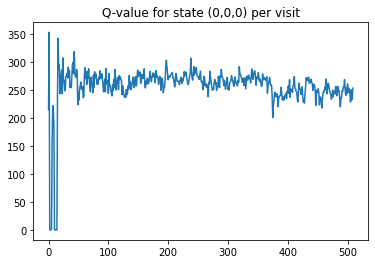

In [142]:
plt.plot(states_to_track[(0,0,0)]) #Tracked state
plt.title("Q-value for state (0,0,0) per visit")
plt.show()

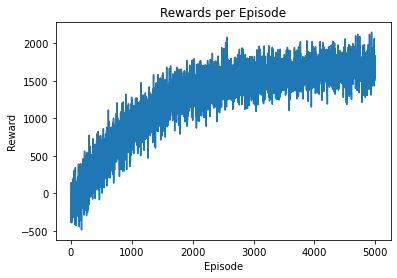

In [133]:
plt.plot(rewards_per_episode)
plt.title("Rewards per Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [29]:
time = np.arange(0,5000)
epsilon = []
for i in range(0,5000):
    epsilon.append(np.exp(-0.0009*i))
    

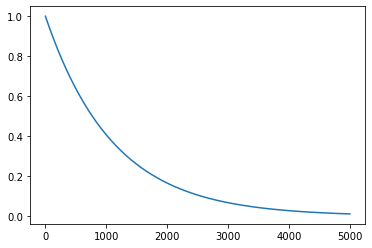

In [30]:
plt.plot(time, epsilon)
plt.show()